In [ ]:
!pip install xlrd
!pip install xgboost 

In [62]:
import pandas as pd
import numpy as np
from numpy import mean, std, absolute
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, LassoLarsIC, BayesianRidge, PoissonRegressor
import xgboost as xg
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

plt.style.use('ggplot')

In [46]:
data = pd.read_excel('Data/Gasification Data_Daya.xlsx', index_col=0, header=0)
data = data.iloc[1:223,:14] 
display(list(data.columns.values))

# Drop null balues and store dataframe in dataframe 2
data=data.dropna()
print(data)

#Check Null values again after removing
print(data.isnull().values.any())
print(data.isna().values.any())

X = data.iloc[:, :9]
y = data.iloc[:, 9:]

input_columns = list(X.columns.values)
output_columns = list(y.columns.values)

print(X.shape, y.shape)

['C [%wt db]',
 'H [%wt db]',
 'O [%wt db]',
 'Moisture [%wt]',
 'Ash [%wt db]',
 'ER [-]',
 'T [ºC]',
 'Bed material',
 'Steam/Biomass',
 'H2 [%vol N2 free]',
 'CO [%vol N2 free]',
 'CO2 [%vol N2 free]',
 'CH4 [%vol N2 free]',
 'GY [Nm3/kg daf]']

        C [%wt db] H [%wt db]  O [%wt db] Moisture [%wt]  Ash [%wt db]  \
Sr No.                                                                   
2            50.00        5.7       44.10             21          0.85   
3            50.00        5.7       44.10             23          0.85   
4            50.00        5.7       44.10             22          0.85   
5            50.00        5.7       44.10             25          0.85   
6            50.00        5.7       44.10             19          0.85   
...            ...        ...         ...            ...           ...   
219          46.85        6.3       45.55              9          1.30   
220          46.85        6.3       45.55              9          1.30   
221          46.76       5.68       39.46           9.94          8.10   
222          46.76       5.68       39.46           9.94          8.10   
223          46.76       5.68       39.46           9.94          8.10   

        ER [-]  T [ºC]  Bed material 

## Multi-output Regression

In [53]:
# constants
methods = ['Linear', 'Ridge', 'RF', 'Bag']
number_of_folds = 11
ridge_reg = [1.0, 10.0, 100.0, 1000.0, 1e6]
n_estimators = [10, 50, 100, 500, 1000]
learning_rate = [1e-3, 0.01, 0.1, 1]
max_depth = 30

In [54]:
methods_extended = []
for met in methods:
    if met == 'Linear':
        methods_extended.append(met)
    elif met == 'Ridge':
        for reg in ridge_reg:
            methods_extended.append(met + '_Reg_' + str(reg))
    elif met == 'RF':
        for rfest in n_estimators:
            methods_extended.append(met + '_est_' + str(rfest))
    elif met == 'Bag':
        for best in n_estimators:
            methods_extended.append(met + '_est_' + str(best))
    elif met == 'GradientBoost':
        for gbest in n_estimators:
            for lr in learning_rate:
                methods_extended.append(met + '_est_' + str(gbest) + 
                                        '_lr_' + str(lr))
print(methods_extended)

['Linear', 'Ridge_Reg_1.0', 'Ridge_Reg_10.0', 'Ridge_Reg_100.0', 'Ridge_Reg_1000.0', 'Ridge_Reg_1000000.0', 'RF_est_10', 'RF_est_50', 'RF_est_100', 'RF_est_500', 'RF_est_1000', 'Bag_est_10', 'Bag_est_50', 'Bag_est_100', 'Bag_est_500', 'Bag_est_1000']


In [55]:
extract = methods_extended[-1].split('_')
print(extract[-3])

Bag


In [56]:
kf = KFold(n_splits=number_of_folds, random_state=number_of_folds, shuffle=True)

prediction = {}
error = {}
for met in methods_extended:
    print(met)
    score = {}
    prediction[met] = np.zeros_like(y) 
    
    string_extract = met.split('_')

    for fold, (train, test) in enumerate(kf.split(y)):
        training_x = np.asarray(X)[train]
        testing_x = np.asarray(X)[test]
        training_y = np.asarray(y)[train]
        testing_y = np.asarray(y)[test]
        
        if string_extract[0] == 'Linear':
            regr_multilin = LinearRegression()
            regr_multilin.fit(training_x, training_y)
            score[fold] = regr_multilin.predict(testing_x)
            
        elif string_extract[0] == 'Ridge':
            regr_multiridge = Ridge(alpha=float(string_extract[-1]))
            regr_multiridge.fit(training_x, training_y)
            score[fold] = regr_multiridge.predict(testing_x)
            
        elif string_extract[0] == 'LARS':
            regr_multilasso = LassoLarsIC()
            regr_multilasso.fit(training_x, training_y)
            score[fold] = regr_multilasso.predict(testing_x)
            
        elif string_extract[0] == 'RF':
            regr_multirf = RandomForestRegressor(n_estimators=int(string_extract[-1]),
                                                                  max_depth=max_depth,
                                                                  random_state=0)
            regr_multirf.fit(training_x, training_y)
            score[fold] = regr_multirf.predict(testing_x)
            
        elif string_extract[0] == 'Bag':
            regr_multibag = BaggingRegressor(n_estimators=int(string_extract[-1]),
                                                                  random_state=0)
            regr_multibag.fit(training_x, training_y)
            score[fold] = regr_multibag.predict(testing_x)
            
        elif string_extract[0] == 'GradientBoost':
            regr_multigb = GradientBoostingRegressor(n_estimators=int(string_extract[-3]), 
                                                                          learning_rate=float(string_extract[-1]),
                                                                          random_state=0, loss='huber')
            regr_multigb.fit(training_x, training_y)
            score[fold] = regr_multigb.predict(testing_x)

    for (train, test), fold in zip(kf.split(y), list(range(number_of_folds))):
        prediction[met][test, :] = score[fold]
    
    error[met] = np.sqrt(mse(y, prediction[met], multioutput='raw_values'))

Linear
Ridge_Reg_1.0
Ridge_Reg_10.0
Ridge_Reg_100.0
Ridge_Reg_1000.0
Ridge_Reg_1000000.0
RF_est_10
RF_est_50
RF_est_100
RF_est_500
RF_est_1000
Bag_est_10
Bag_est_50
Bag_est_100
Bag_est_500
Bag_est_1000


In [ ]:
print(prediction['GradientBoost'])

## Plotting the result

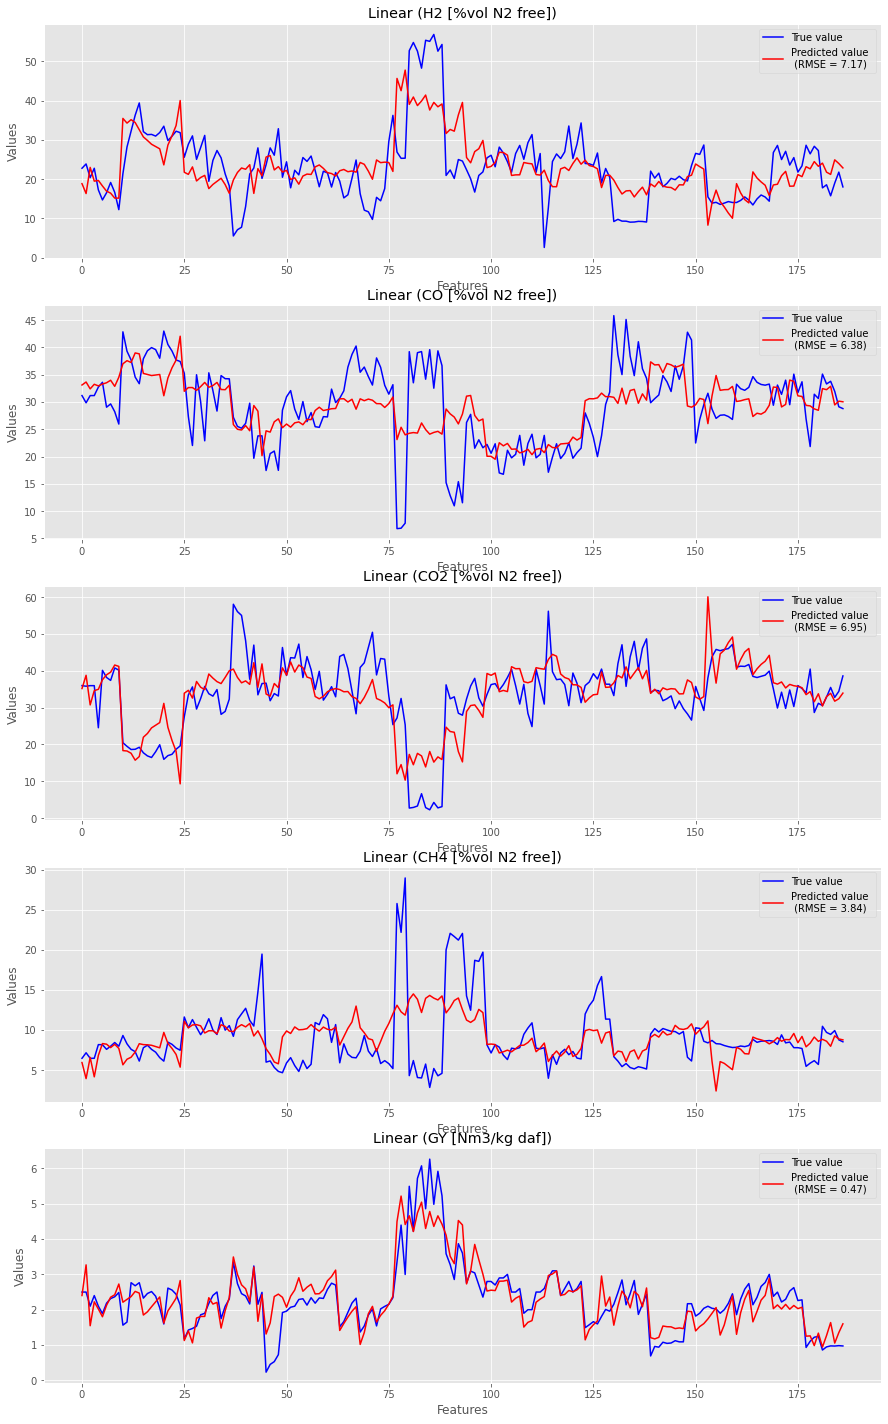

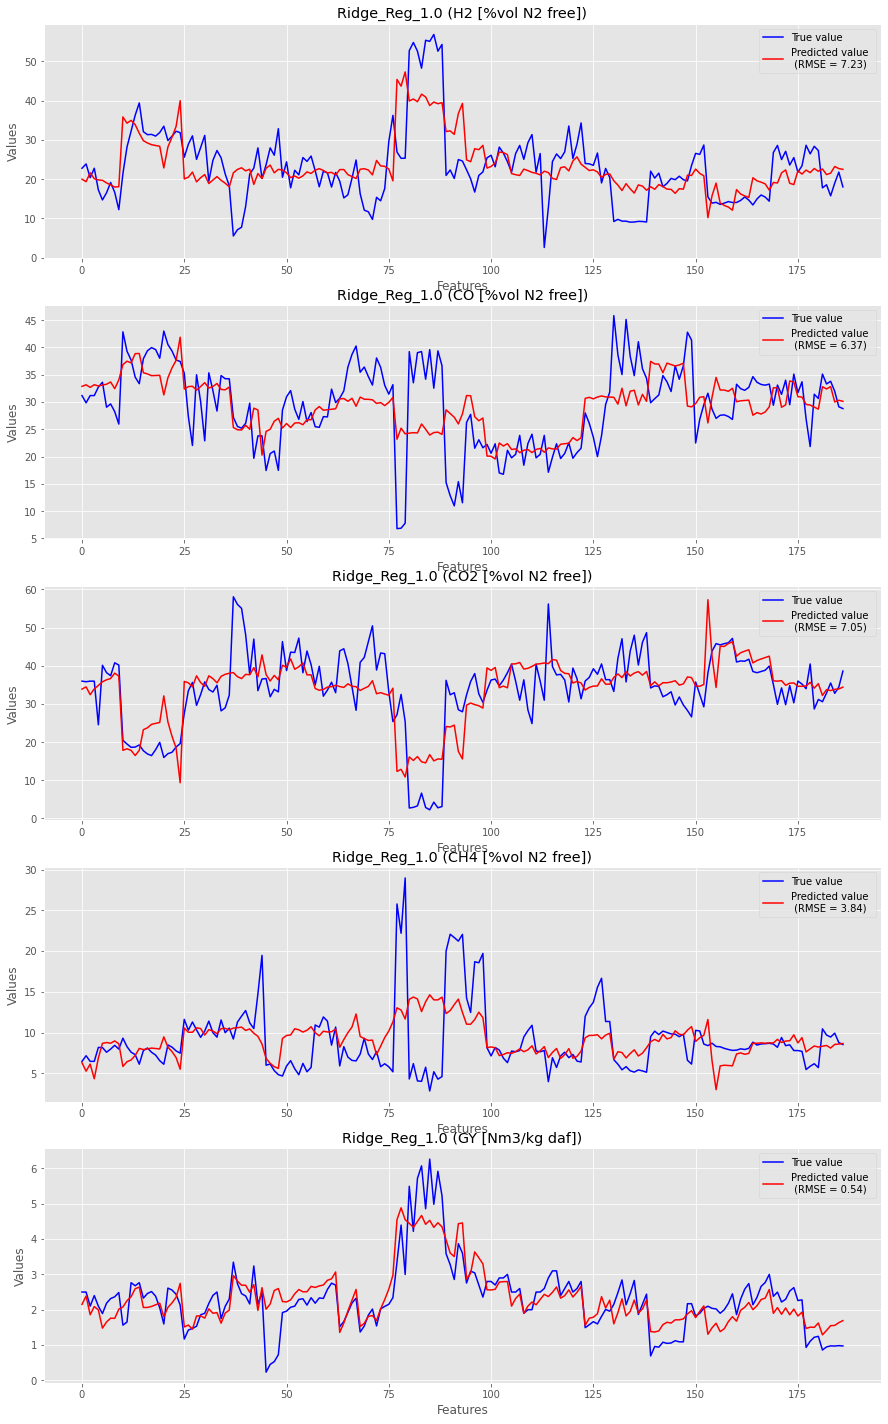

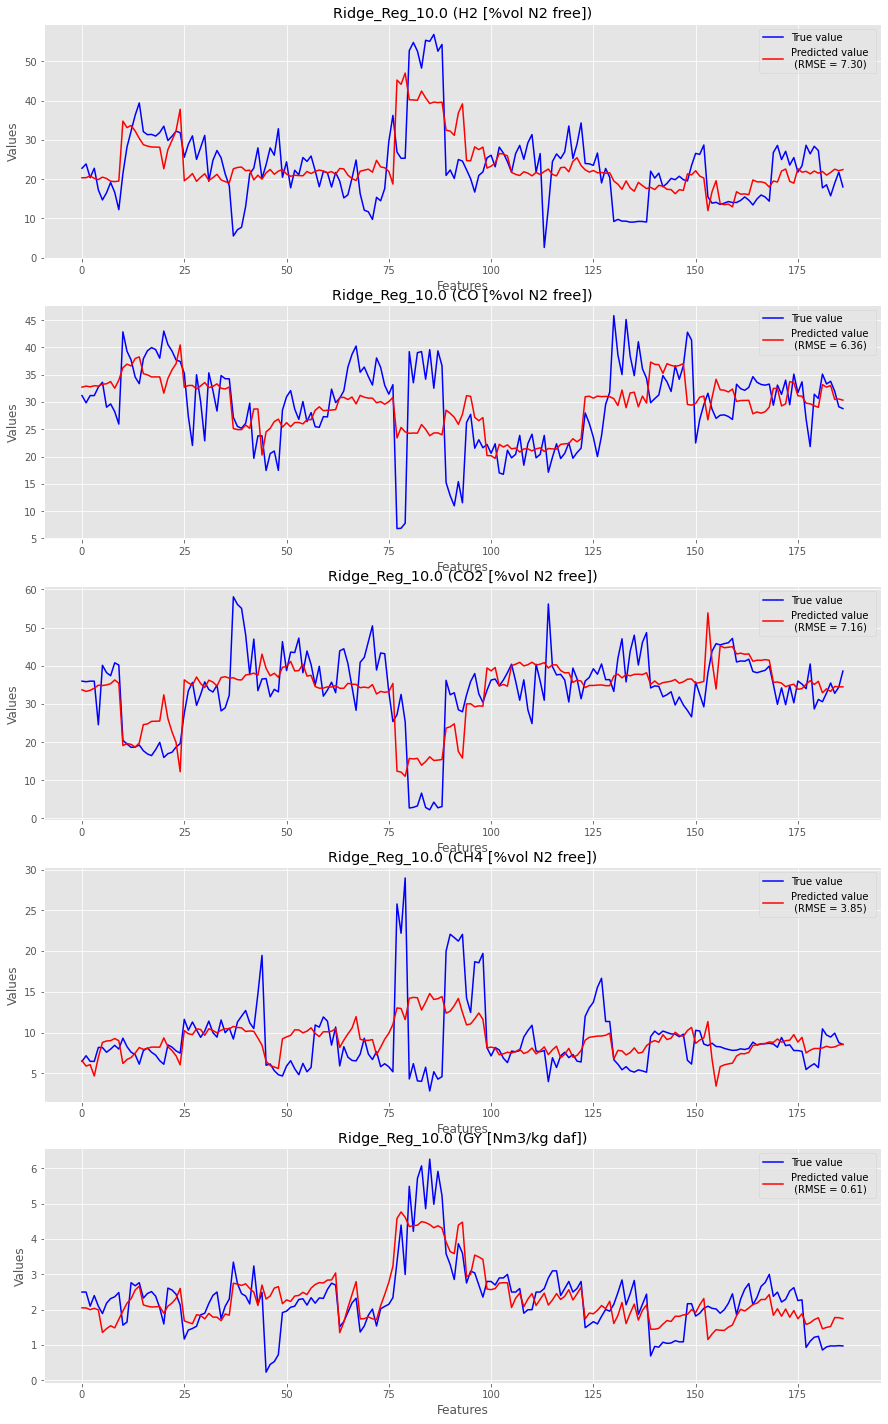

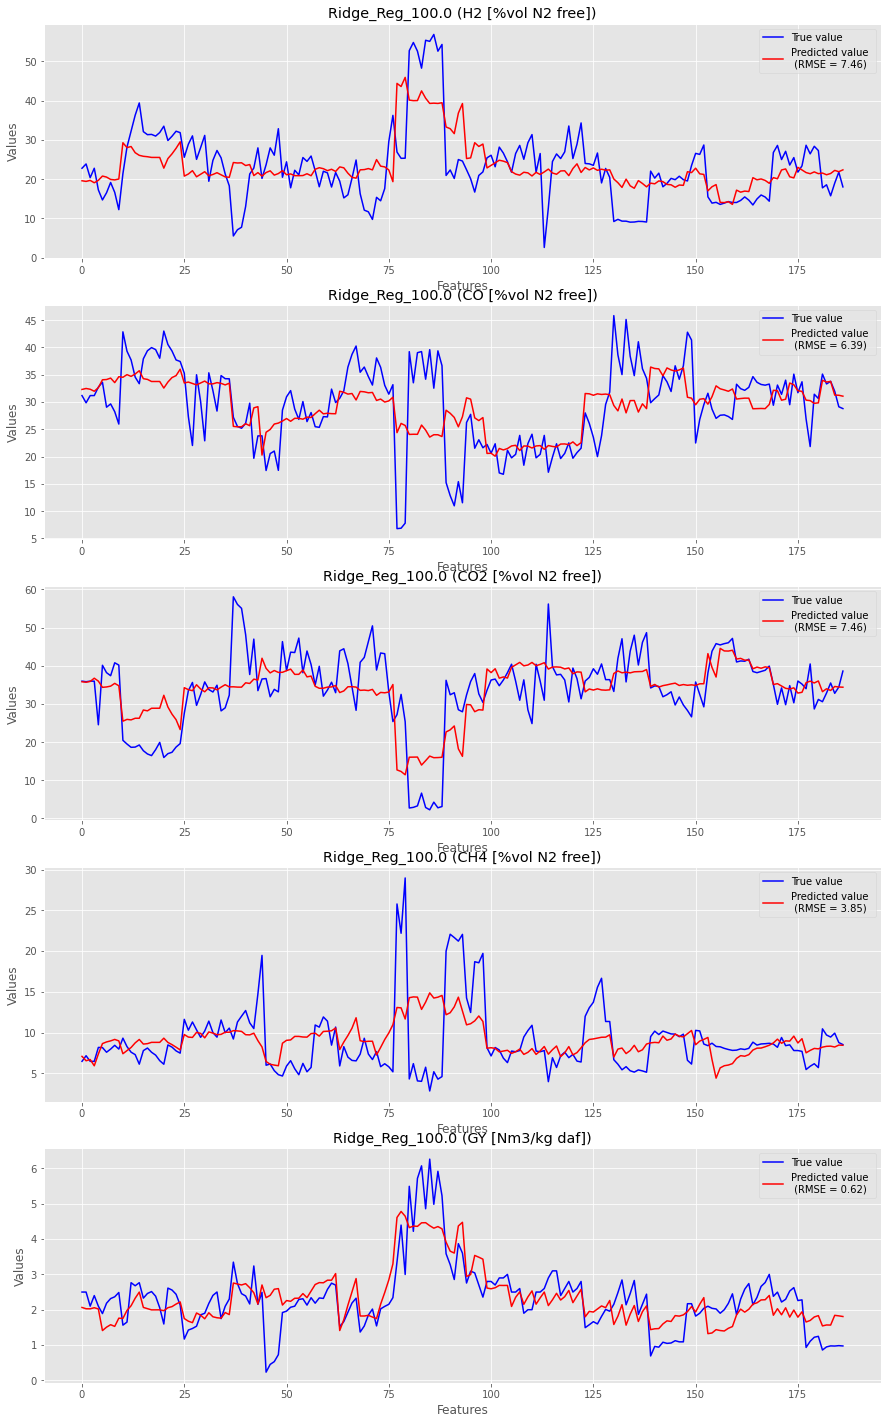

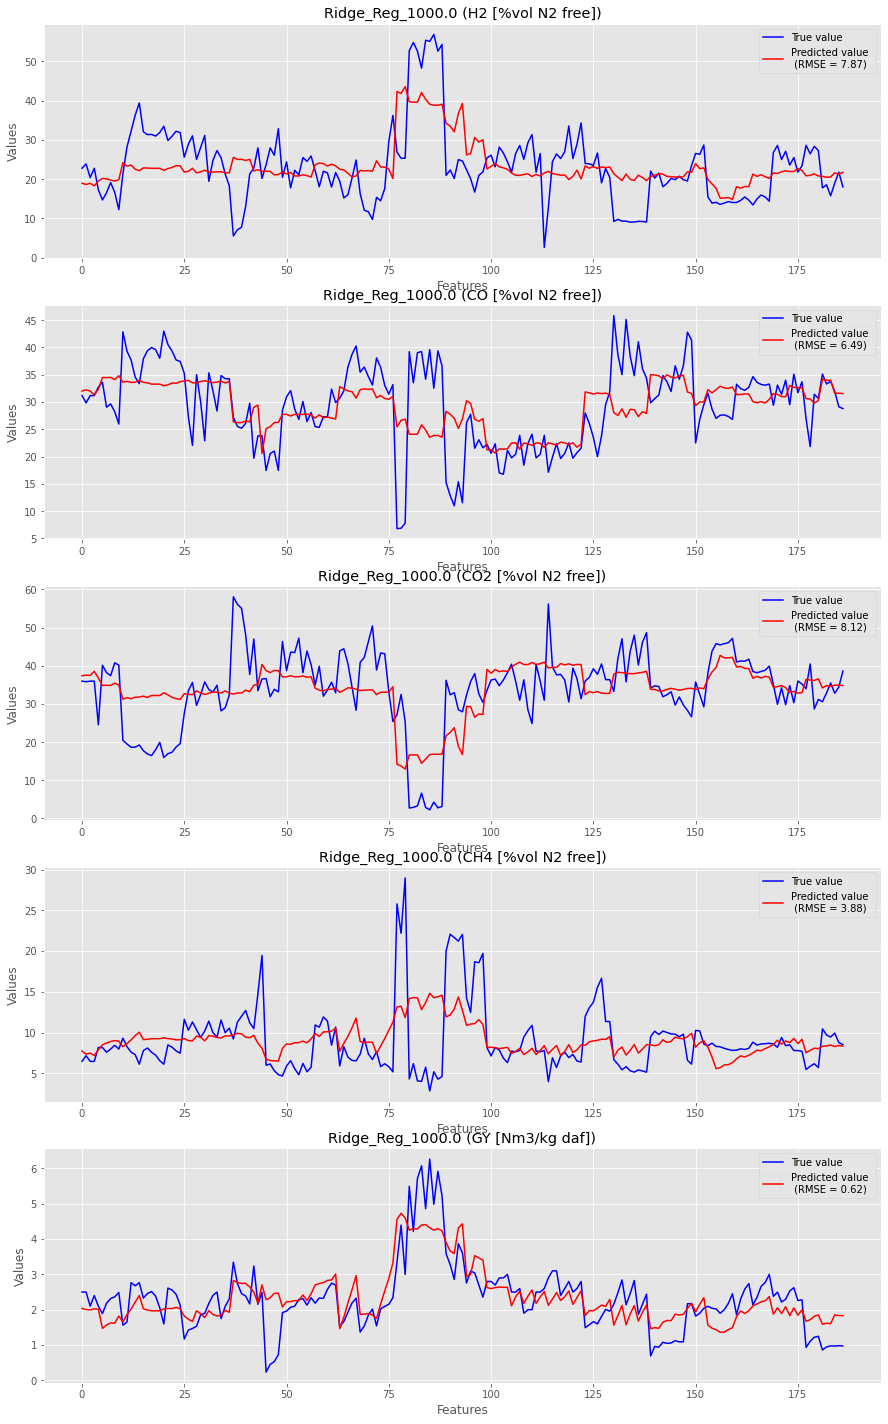

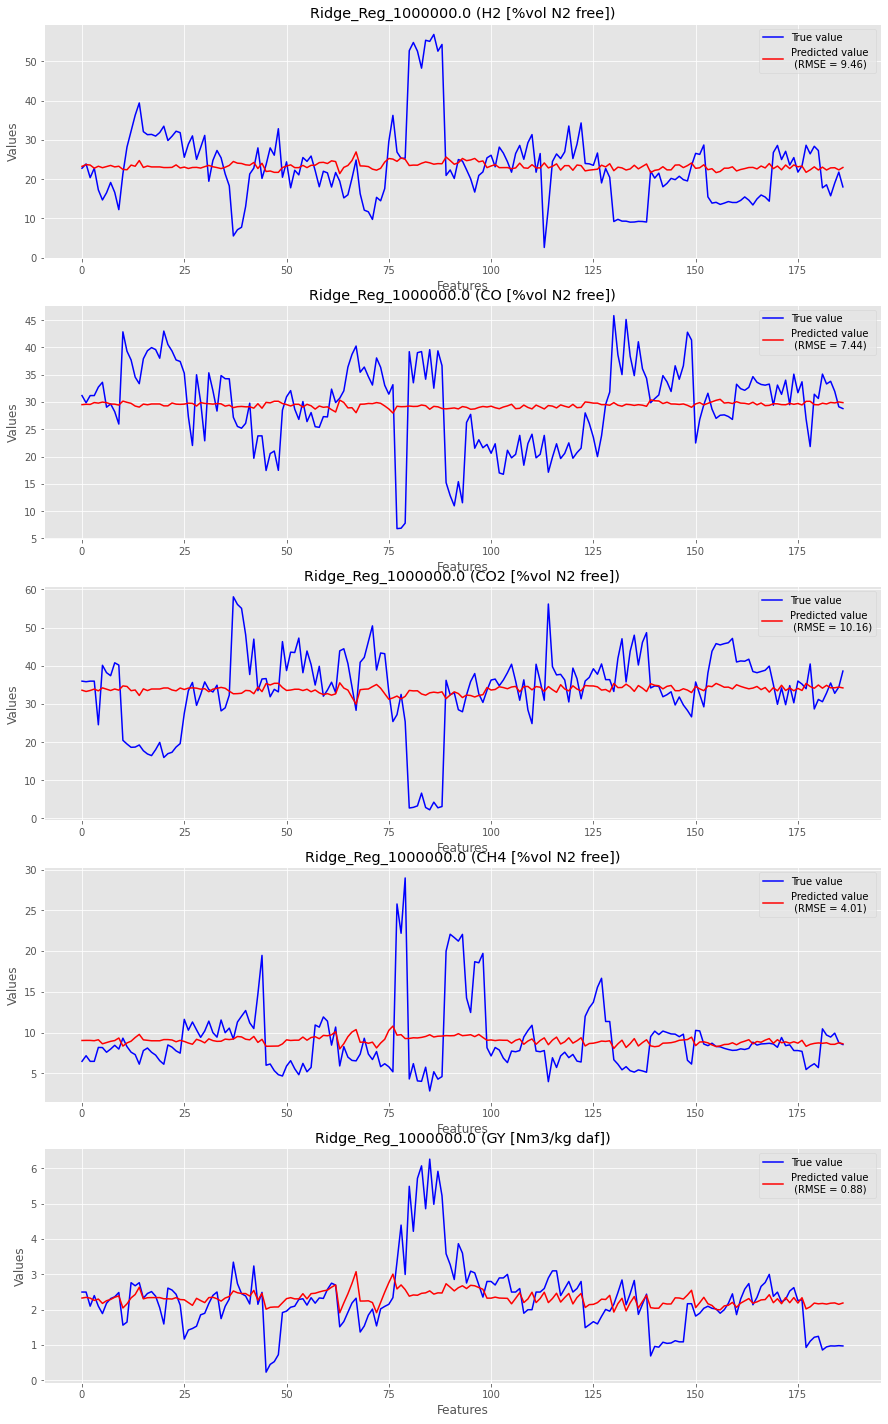

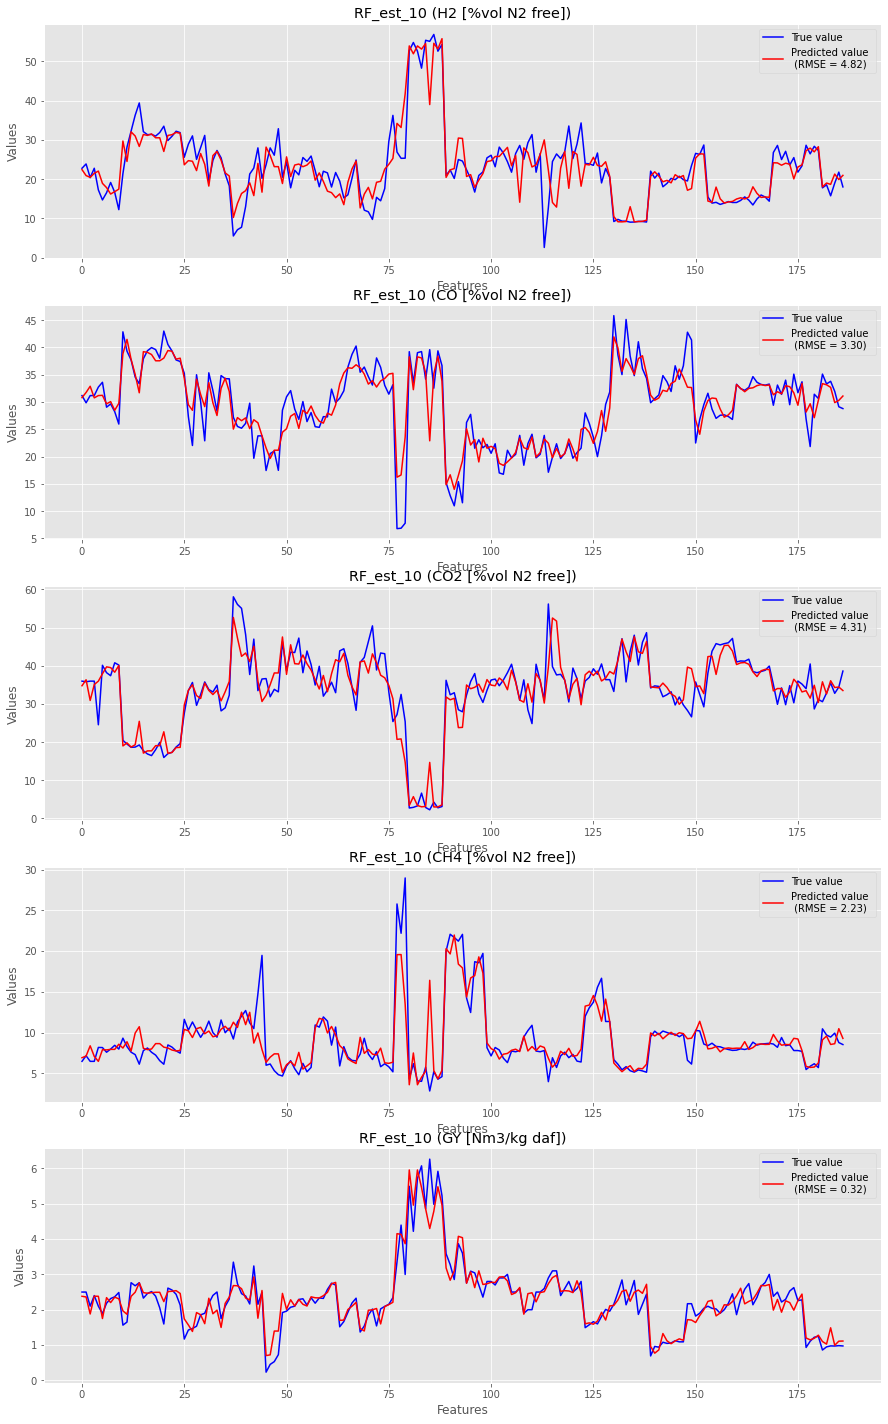

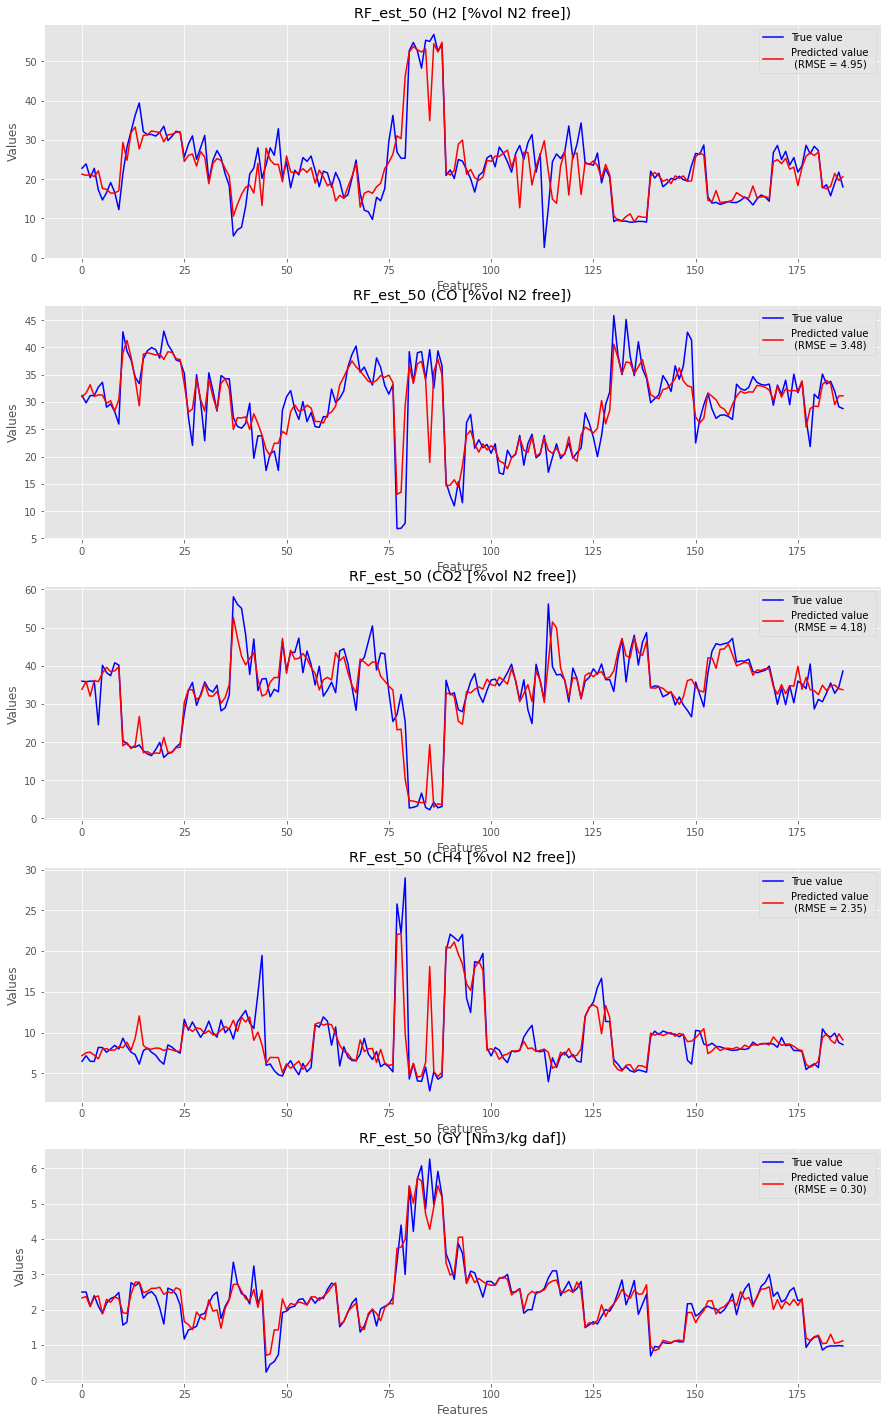

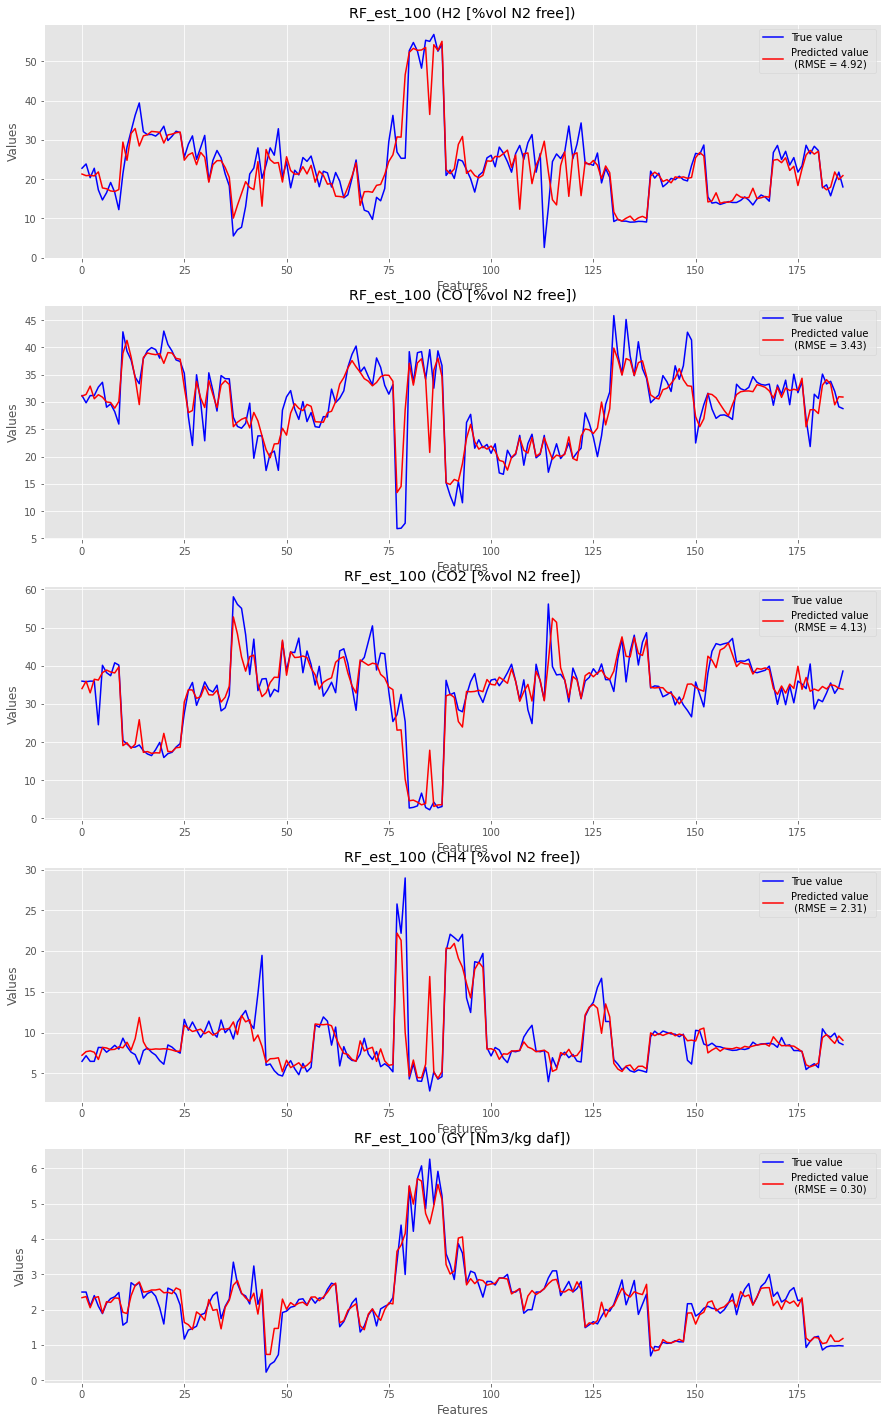

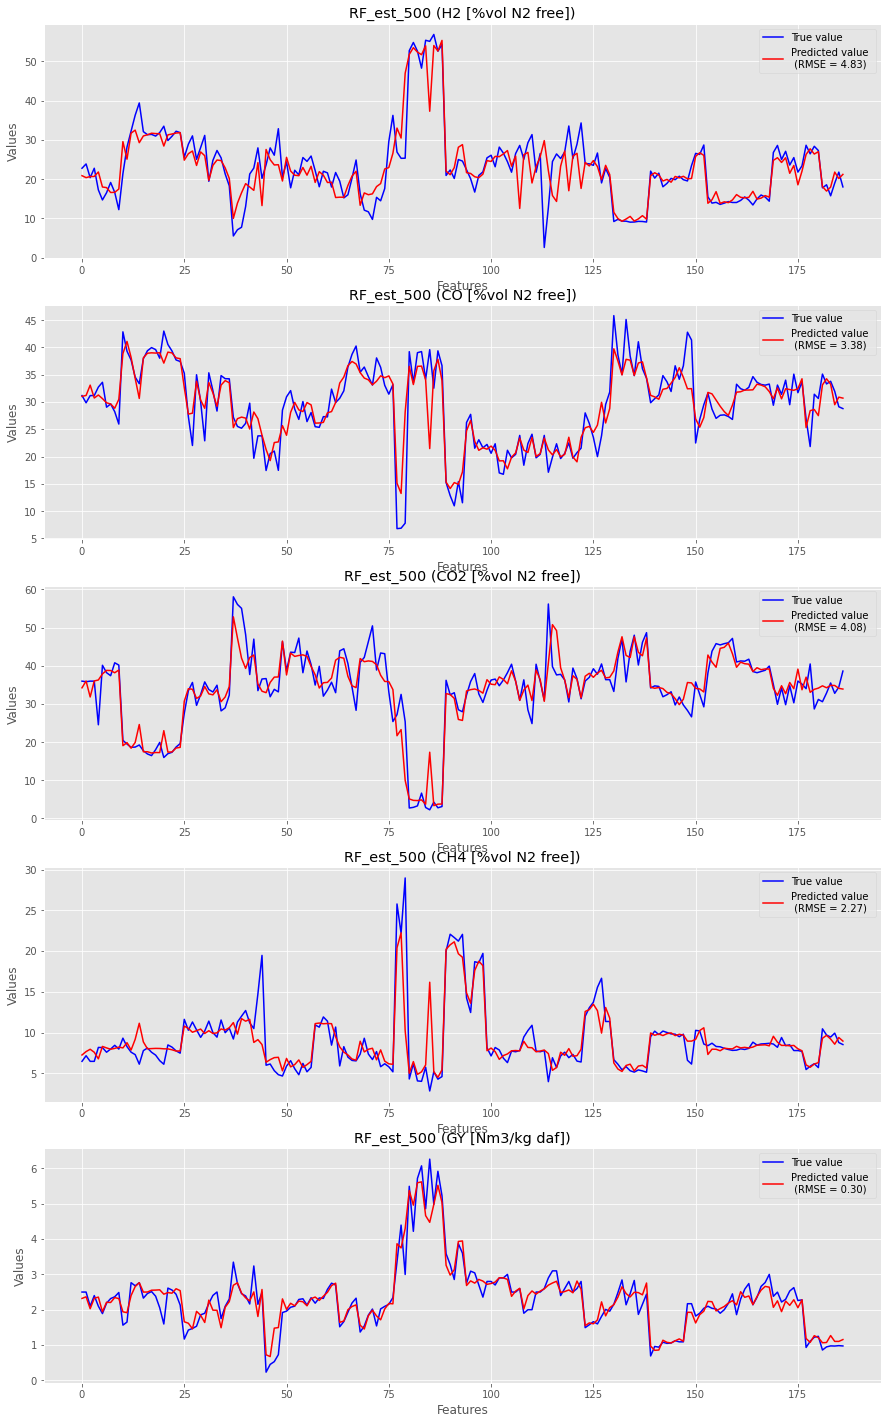

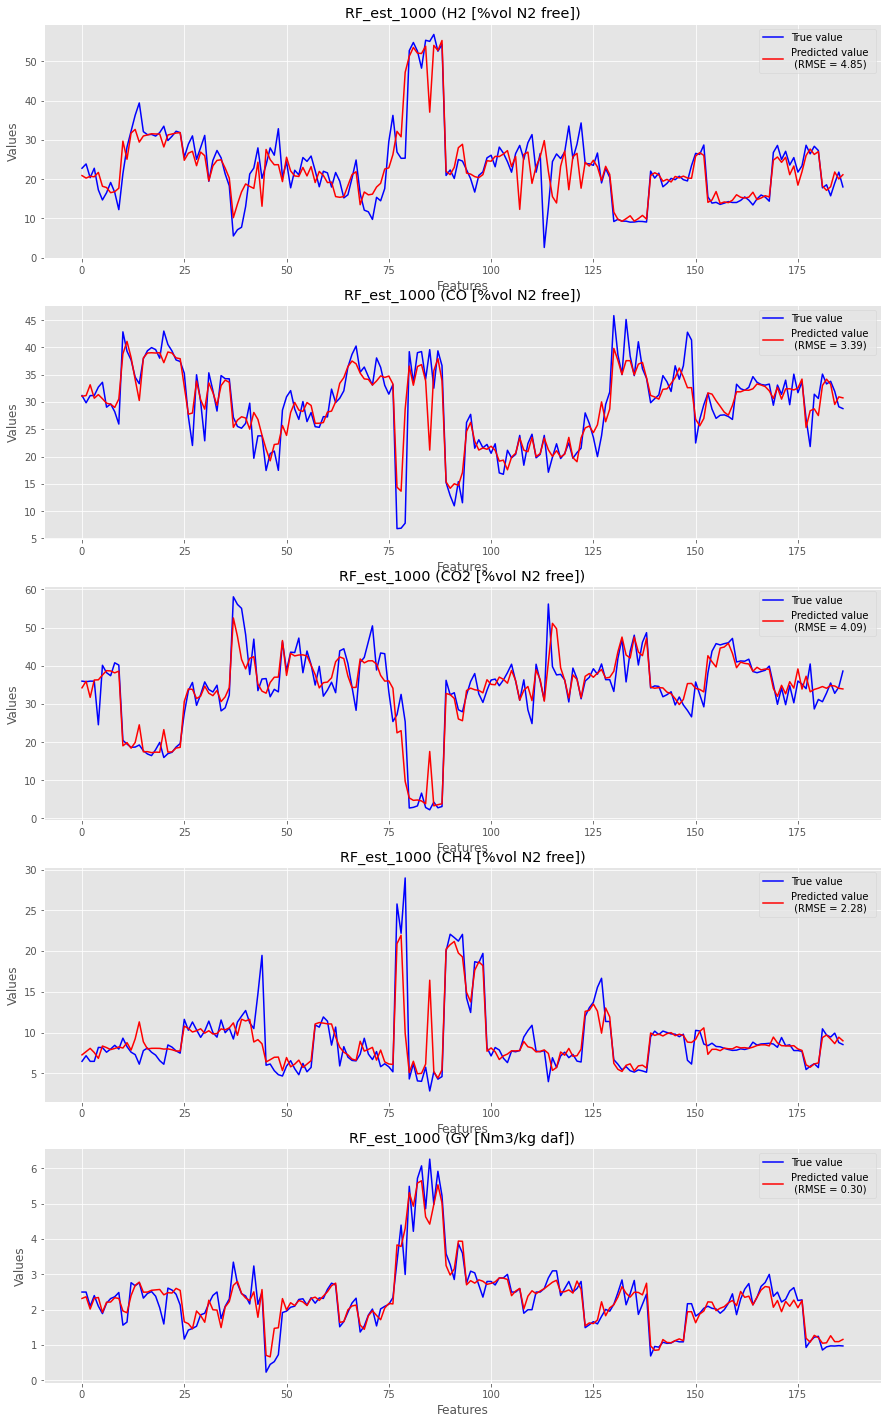

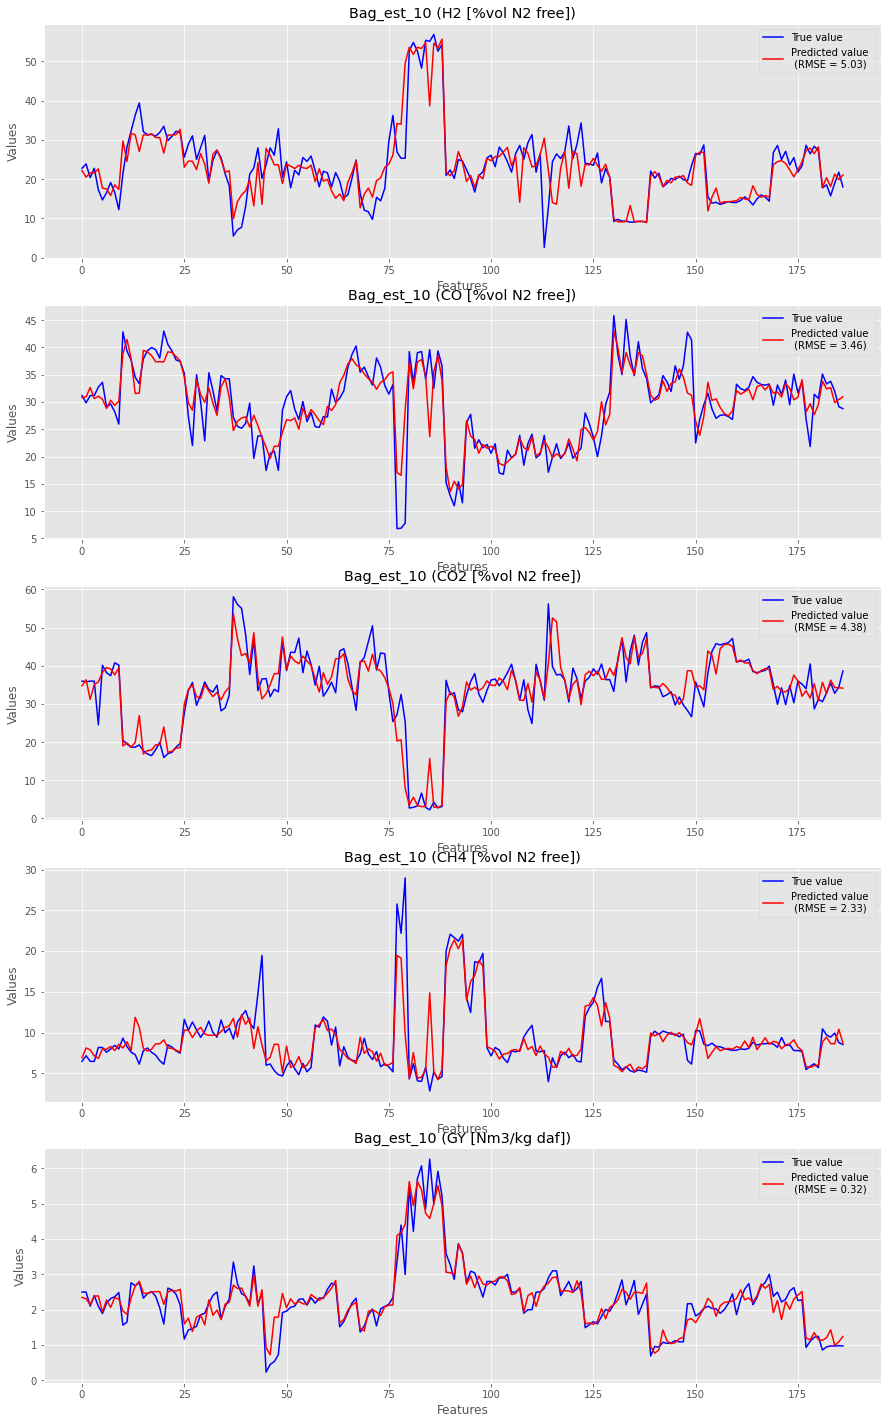

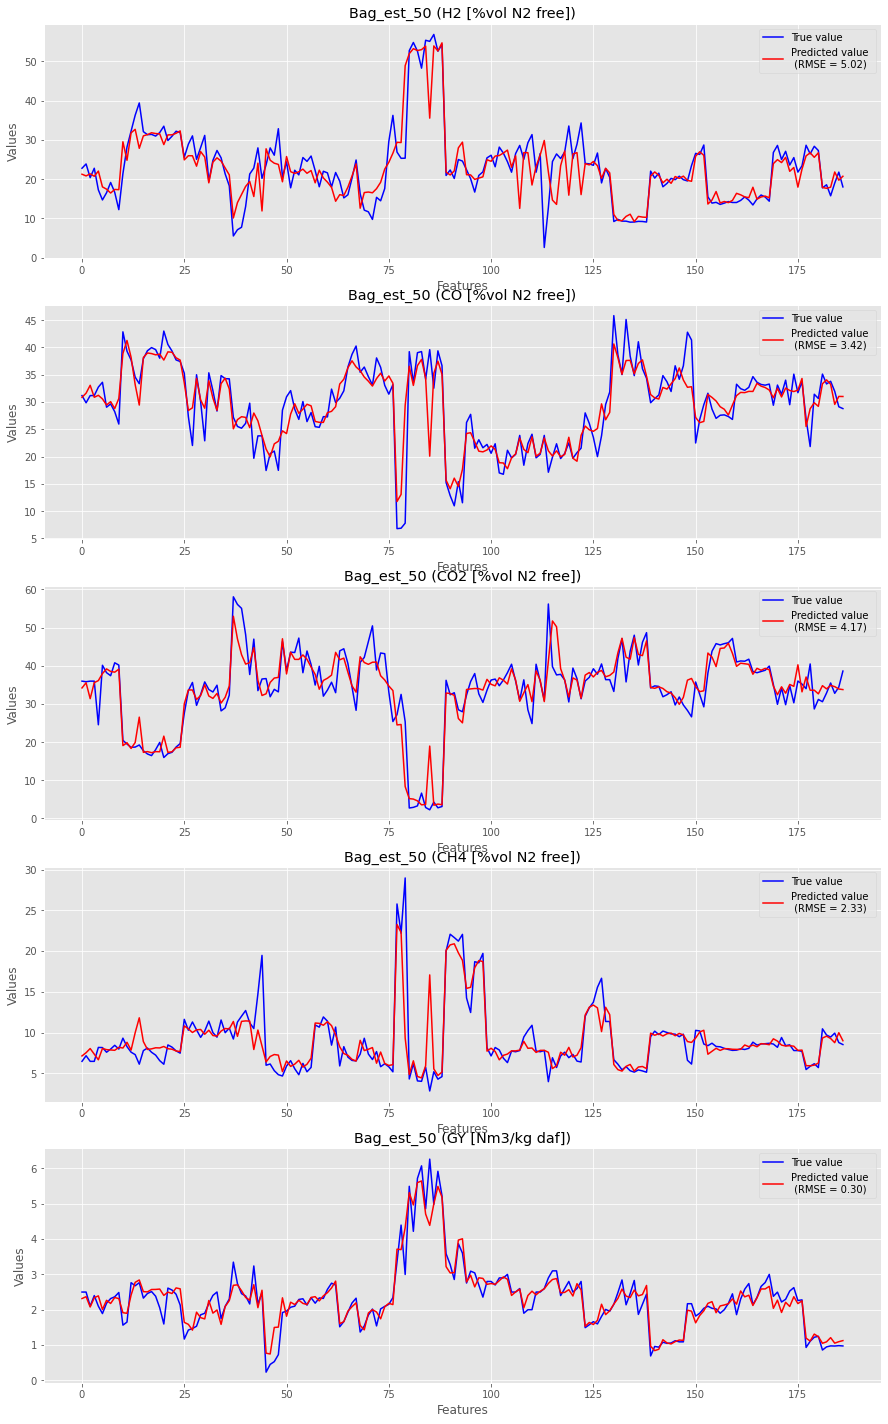

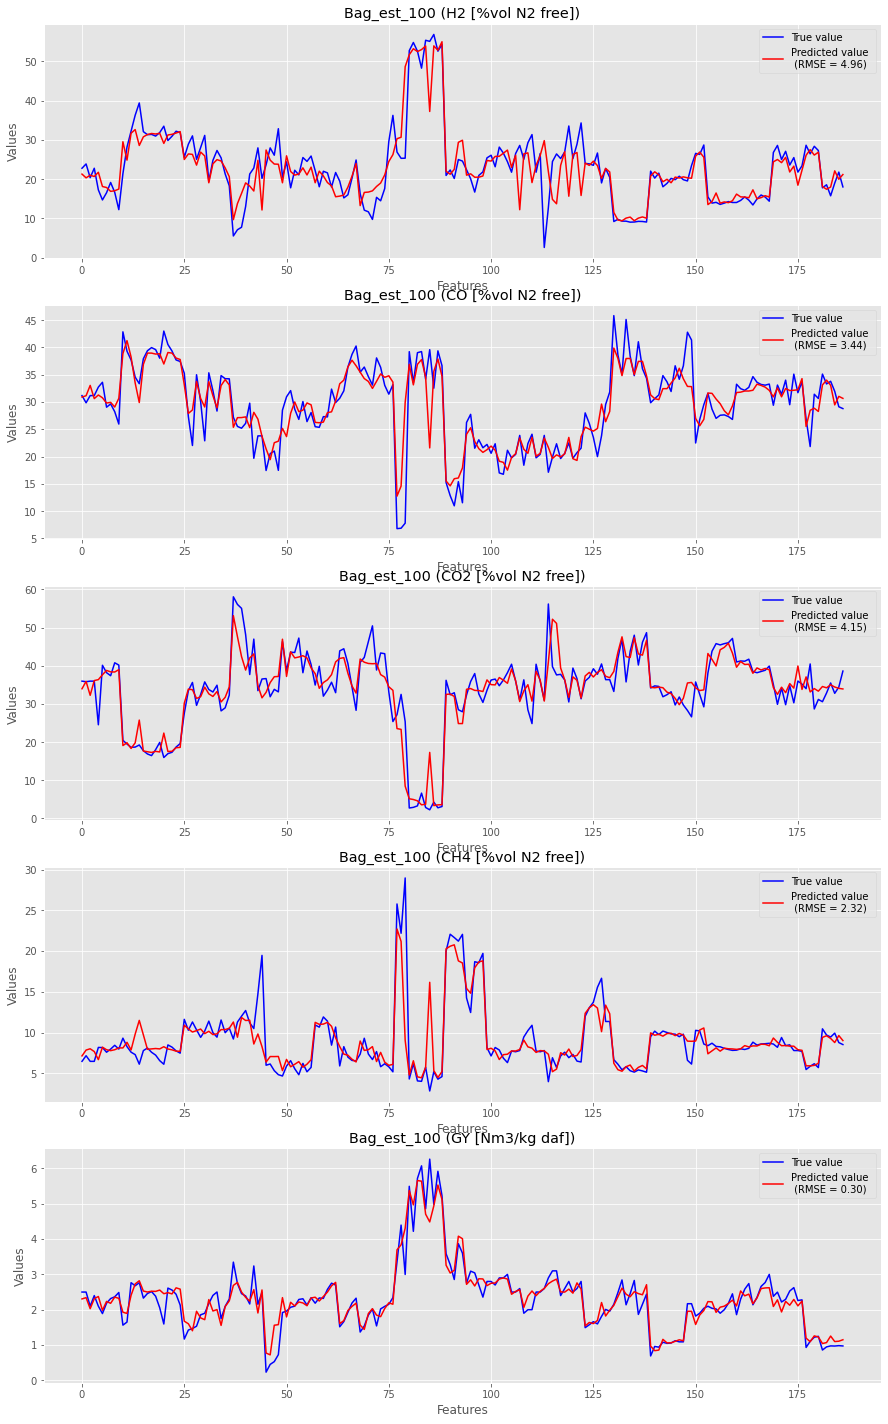

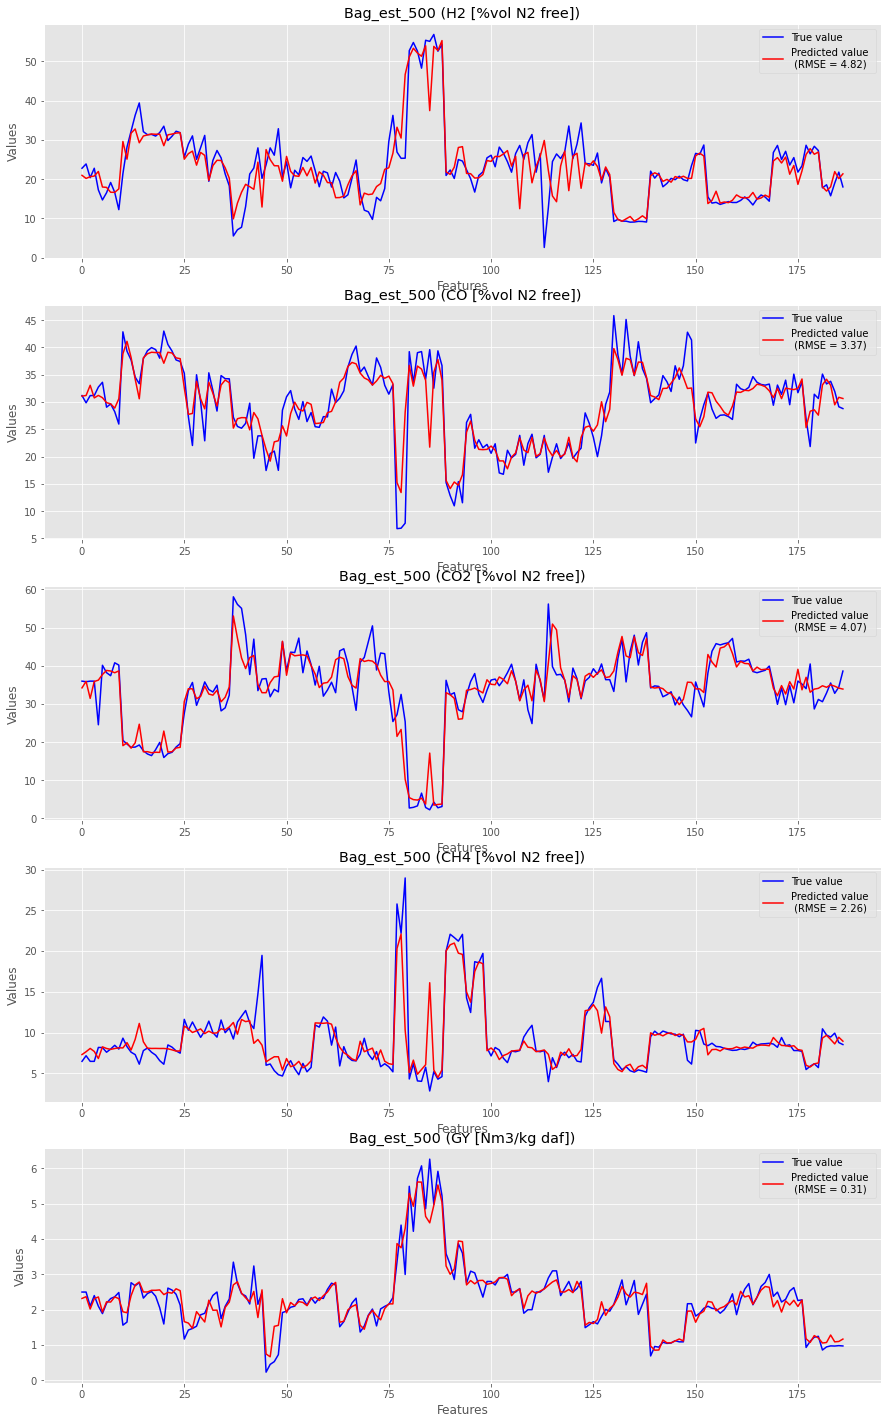

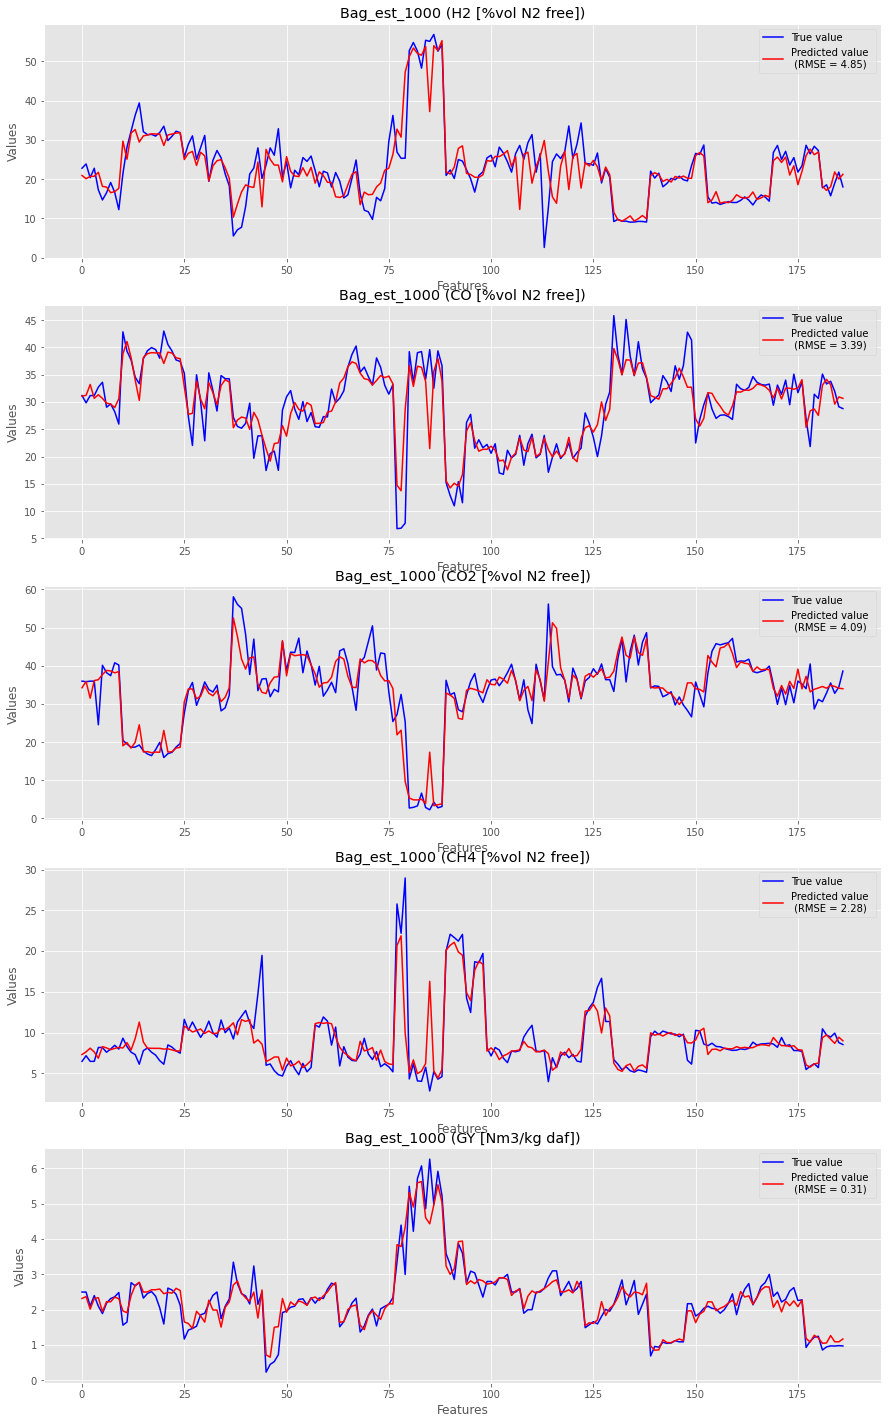

In [59]:
for fold, (train, test) in enumerate(kf.split(y)):
    training_x = np.asarray(X)[train]
    testing_x = np.asarray(X)[test]
    training_y = np.asarray(y)[train]
    testing_y = np.asarray(y)[test]
        
### Plot
for met in methods_extended:
    plt.figure(figsize=(15, 25))
    for odx, out in enumerate(output_columns):
        plt.subplot(5, 1, odx +1)
        plt.plot(np.asarray(y)[:, odx], label='True value', color='blue')
        plt.plot(np.asarray(prediction[met])[:, odx], color='red', label='Predicted value \n (RMSE = %.2f)' % error[met][odx])
        plt.xlabel("Features")
        plt.ylabel("Values")
        plt.title("%s (%s)" % (met, out))
        plt.legend()

    plt.savefig('Figures/MIMO/Prediction_%s.pdf' % met)
#     plt.show()

## Feature Importance

Feature ranking:
1. feature 1 (0.258338)
2. feature 6 (0.165396)
3. feature 2 (0.150055)
4. feature 0 (0.094843)
5. feature 5 (0.076423)
6. feature 7 (0.075399)
7. feature 3 (0.071106)
8. feature 8 (0.056890)
9. feature 4 (0.051551)
Feature ranking:
1. feature 1 (0.258338)
2. feature 6 (0.165396)
3. feature 2 (0.150055)
4. feature 0 (0.094843)
5. feature 5 (0.076423)
6. feature 7 (0.075399)
7. feature 3 (0.071106)
8. feature 8 (0.056890)
9. feature 4 (0.051551)
Feature ranking:
1. feature 1 (0.258338)
2. feature 6 (0.165396)
3. feature 2 (0.150055)
4. feature 0 (0.094843)
5. feature 5 (0.076423)
6. feature 7 (0.075399)
7. feature 3 (0.071106)
8. feature 8 (0.056890)
9. feature 4 (0.051551)
Feature ranking:
1. feature 1 (0.258338)
2. feature 6 (0.165396)
3. feature 2 (0.150055)
4. feature 0 (0.094843)
5. feature 5 (0.076423)
6. feature 7 (0.075399)
7. feature 3 (0.071106)
8. feature 8 (0.056890)
9. feature 4 (0.051551)
Feature ranking:
1. feature 1 (0.258338)
2. feature 6 (0.165396)
3. 

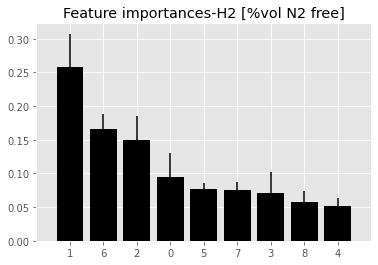

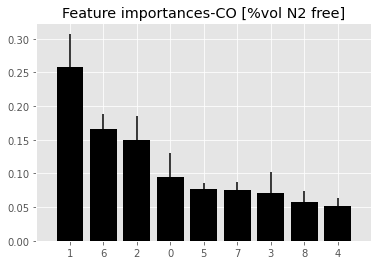

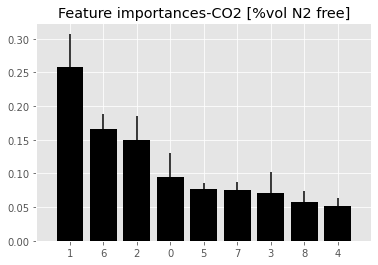

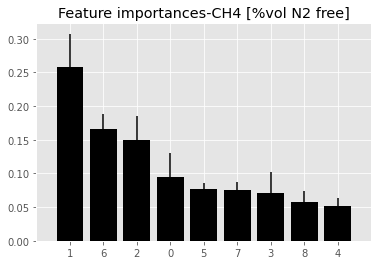

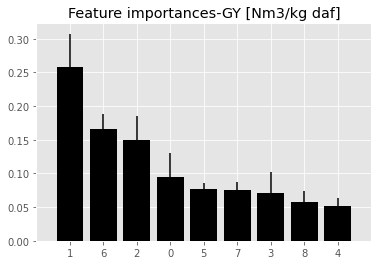

In [60]:
importances={}
std = {}
indices = {}
for idx in range(y.shape[1]):
    importances[idx]=[]
    std[idx]=[]
    for fold, (train, test) in enumerate(kf.split(y)):
        training_x = np.asarray(X)[train]
        testing_x = np.asarray(X)[test]
        training_y = np.asarray(y)[train]
        testing_y = np.asarray(y)[test]
        
        regr = RandomForestRegressor(n_estimators=10, max_depth=max_depth, random_state=0)
        regr.fit(training_x, training_y)
        
        importances[idx].append(regr.feature_importances_)
    mean_importance = np.array(importances[idx]).mean(axis=0)
    std_importance = np.array(importances[idx]).std(axis=0)
        
    indices[idx] = np.argsort(mean_importance)[::-1]
    
    # Print the feature ranking
    features=[]
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[idx][f], mean_importance[indices[idx][f]]))
        features.append(input_columns[indices[idx][f]])

    # Plot the impurity-based feature importances
    plt.figure()
    plt.title("Feature importances-%s" % output_columns[idx])
    plt.bar(range(X.shape[1]), mean_importance[indices[idx]],
            color="k", yerr=std_importance[indices[idx]], align="center")
    plt.xticks(range(X.shape[1]), indices[idx], fontsize=10)
    plt.xlim([-1, X.shape[1]])
    plt.savefig('Figures/MIMO/Feature_Importance_'+ str(idx) +'.pdf')

## Correlation Analysis

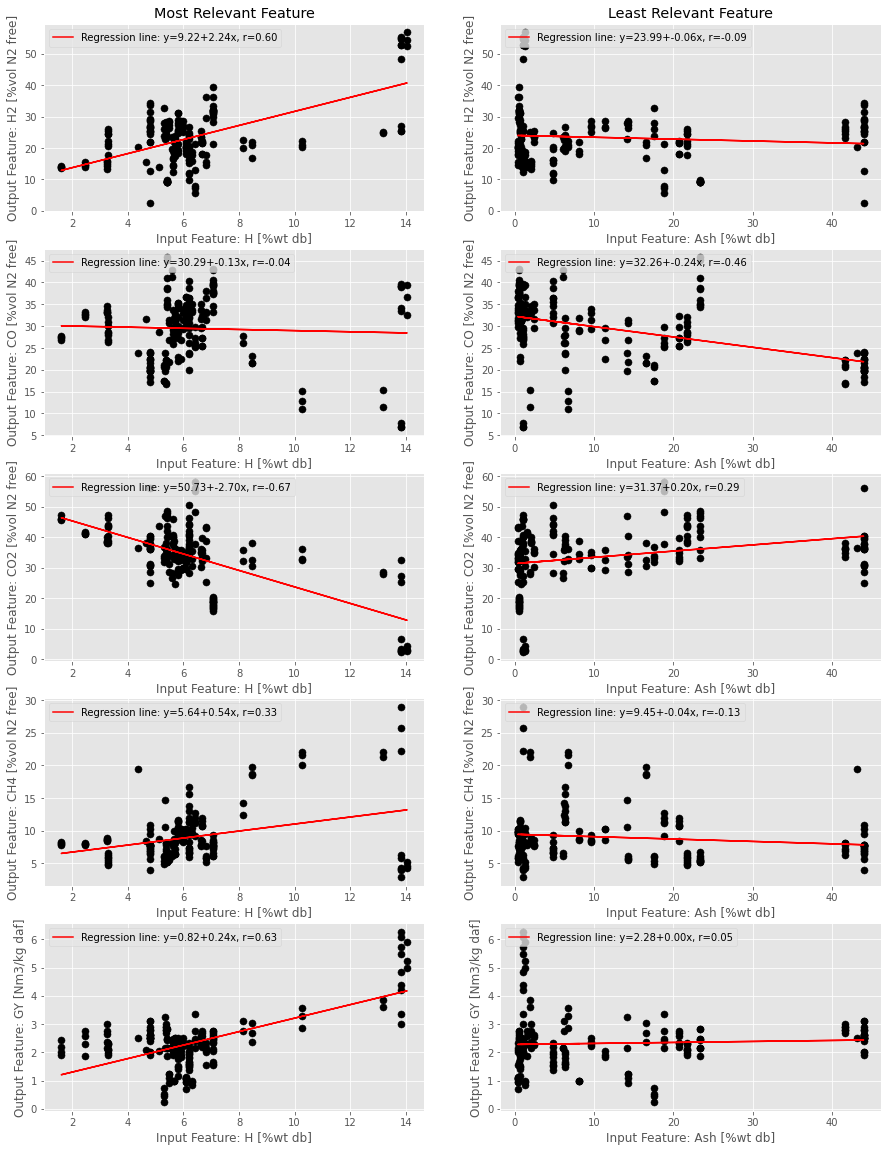

In [63]:
## Correlation analysis for best feature
plt.figure(figsize=(15, 20))
for odx, out in enumerate(output_columns):
    best_feature_indice = indices[odx][0]   
    plt.subplot(5, 2, 2*odx +1)
    plt.scatter(X[input_columns[best_feature_indice]], y[out], s=50, color='black')
    slope, intercept, r, p, stderr = sp.stats.linregress(X[input_columns[best_feature_indice]].astype(float), 
                                                         y[out].astype(float))
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    plt.plot(X[input_columns[best_feature_indice]], intercept + slope * X[input_columns[best_feature_indice]], 
             label=line, color='red')
    plt.xlabel("Input Feature: %s" % input_columns[best_feature_indice])
    plt.ylabel("Output Feature: %s" % out)
    if odx==0:
        plt.title("Most Relevant Feature")
    plt.legend(loc='upper left')
    
    plt.subplot(5, 2, 2*odx +2)
    worst_feature_indice = indices[odx][-1]   
    plt.scatter(X[input_columns[worst_feature_indice]], y[out], s=50, color='black')
    slope, intercept, r, p, stderr = sp.stats.linregress(X[input_columns[worst_feature_indice]].astype(float), 
                                                         y[out].astype(float))
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    plt.plot(X[input_columns[worst_feature_indice]], intercept + slope * X[input_columns[worst_feature_indice]], 
             label=line, color='red')
    plt.xlabel("Input Feature: %s" % input_columns[worst_feature_indice])
    plt.ylabel("Output Feature: %s" % out)
    if odx == 0:
        plt.title("Least Relevant Feature")
    plt.legend(loc='upper left')
plt.savefig('Figures/MIMO/Correlation_analysis.pdf')